## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer



## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
digits = load_digits()

X, labels = digits.data, digits.target
(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


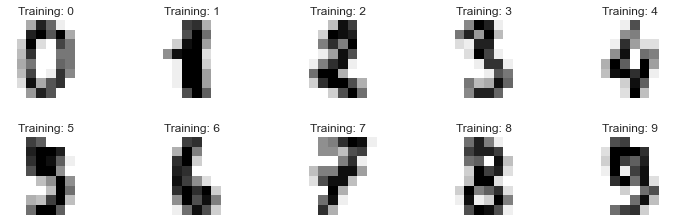

In [3]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
axes = axes.flatten()
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)
for ax, image, label in zip(axes, digits.images, labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [4]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180]))

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [5]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [9]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.175s	69662	0.680	0.719	0.699	0.570	0.178
random   	0.080s	69707	0.675	0.716	0.694	0.560	0.163
PCA-based	0.025s	72686	0.636	0.658	0.647	0.521	0.145
__________________________________________________________________________________


## Optimal number of clusters

### Elbow method

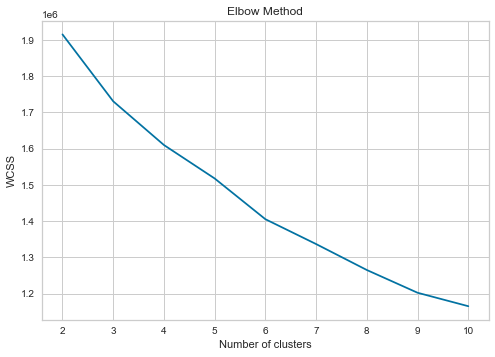

In [12]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

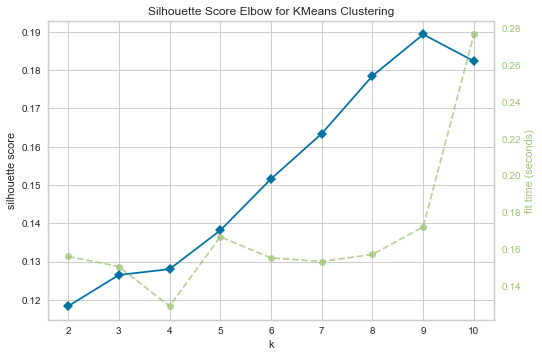

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [17]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',
                              timings=True,
                              locate_elbow=False,
                              k=(2,11),
                             )

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualize the results on PCA-reduced data


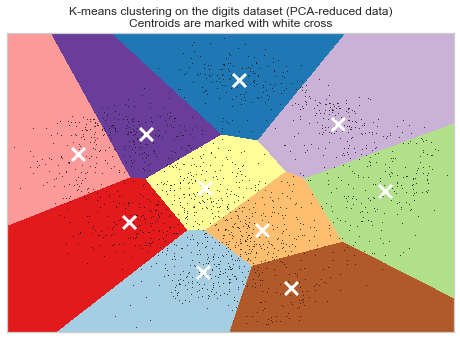

In [20]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

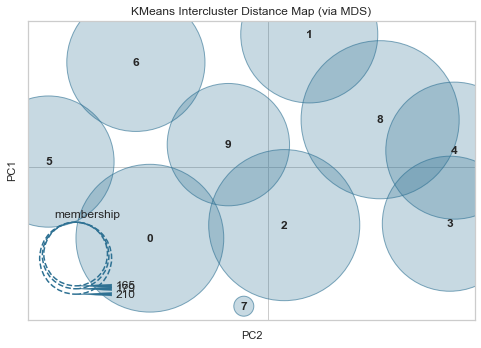

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [23]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure